# Defaults & Charge-off Prediction

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

In [10]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from keras.src.callbacks import EarlyStopping
from keras.src.layers import Dense, BatchNormalization, Dropout
from keras.src.models import Sequential
from keras.src.optimizers import Adam
from optuna import visualization as vis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# load the data
loan3a = pd.read_csv('../data/LoanStats3a_securev1.csv', header=1, low_memory=False)
loan3b = pd.read_csv('../data/LoanStats3b_securev1.csv', header=1, low_memory=False)
loan3c = pd.read_csv('../data/LoanStats3c_securev1.csv', header=1, low_memory=False)
loan3d = pd.read_csv('../data/LoanStats3d_securev1.csv', header=1, low_memory=False)

In [14]:
loan3a

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,72176,70868.0,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42534,71623,70735.0,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42535,70686,70681.0,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1: 471701350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# combine the data
df = pd.concat([loan3a, loan3b, loan3c, loan3d], axis=0)

In [16]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,36271333,38982739.0,13000.0,13000.0,13000.0,60 months,15.99%,316.07,D,D2,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806,39222577.0,12000.0,12000.0,12000.0,60 months,19.99%,317.86,E,E3,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262,38982659.0,20000.0,20000.0,20000.0,36 months,11.99%,664.20,B,B5,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# remove first dataframes from memory
del loan3a
del loan3b
del loan3c
del loan3d

In [18]:
# display all types of loan_status
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

### Drop Unnecessary Variables

In [19]:
# drop the columns that are not needed
df.drop(['id', 'member_id', 'emp_title', 'pymnt_plan', 'url', 'desc', 'title', 'policy_code', 'application_type',
         'annual_inc_joint', 'dti_joint', 'verification_status_joint'], axis=1, inplace=True)

# drop columns with more than 80% missing values
missing_values = df.isnull().mean()
missing_values = missing_values[missing_values > 0.8]

df.drop(missing_values.index, axis=1, inplace=True)

In [20]:
# drop direct indicators
direct_indicators = [
    'collection_recovery_fee',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'out_prncp',
    'out_prncp_inv',
    'recoveries',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
]

df.drop(direct_indicators, axis=1, inplace=True)

In [21]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,13000.0,13000.0,13000.0,60 months,15.99%,316.07,D,D2,5 years,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99%,317.86,E,E3,1 year,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99%,664.20,B,B5,10+ years,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert Variables

In [22]:
# convert int_rate from percentage to float
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)

# convert revol_util from percentage to float
'''df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)'''

"df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)"

In [23]:
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0.5,
    'n/a': 0
}

df['emp_length'] = df['emp_length'].map(emp_length_mapping)

In [24]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10.0,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,0.5,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10.0,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10.0,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1.0,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,5.0,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,1.0,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,B5,10.0,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Handle Missing Values

In [25]:
# impute values
# for object variables - Get the mode of next payment date and last payment date and the last date credit amount was pulled
for column in ["last_pymnt_d", "last_credit_pull_d"]:  #, 'income_category'
    df[column] = df.groupby("addr_state")[column].transform(lambda x: x.fillna(x.mode()))

# for numerical variables
# Get the mode on the number of accounts in which the client is delinquent
df["pub_rec"] = df.groupby("addr_state")["pub_rec"].transform(lambda x: x.fillna(x.median()))
# Get the mode of the total number of credit lines the borrower has
df["total_acc"] = df.groupby("addr_state")["total_acc"].transform(lambda x: x.fillna(x.median()))

# Get the mean of the annual income depending on the region the client is located.
df["annual_inc"] = df.groupby("addr_state")["annual_inc"].transform(lambda x: x.fillna(x.mean()))
# Mode of credit delinquencies in the past two years.
df["delinq_2yrs"] = df.groupby("addr_state")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [26]:
# for other, fill in with zero
df.fillna(0, inplace=True)
df.isnull().sum().max() # Maximum number of nulls.

0

In [27]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10.0,RENT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,0.5,RENT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10.0,RENT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10.0,RENT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1.0,RENT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,5.0,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,1.0,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,B5,10.0,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,0.0,0.0,0.0,0,0.00,0.00,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert Target Variable to Binary

In [28]:
# drop any loans that are 'current'
df = df[~df['loan_status'].isin(['Current'])]

In [29]:
# map loan_status to multiple categories
df['loan_status'] = df['loan_status'].map({
    'Fully Paid': 0,
    'In Grace Period': 1,
    'Late (16-30 days)': 1,
    'Late (31-120 days)': 1,
    'Charged Off': 1,
    'Default': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1
})

<ipython-input-29-ac78ecc10f32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].map({


In [30]:
df = df.dropna()

### Save Data

## Exploratory Data Analysis

In [ ]:
# save to pickle
df.to_pickle('../data/cleaned.pkl')

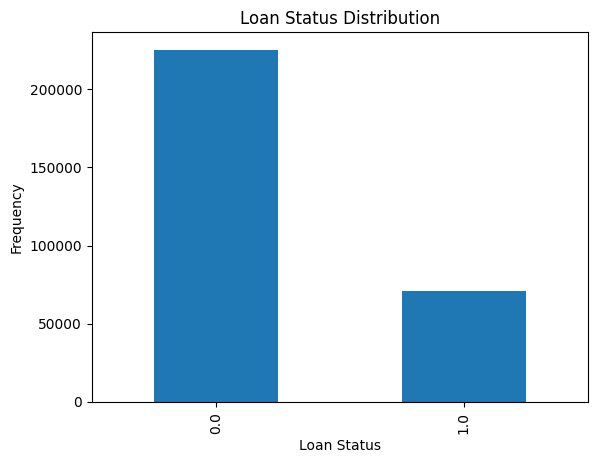

In [32]:
# plot the distribution of loan_status
# change the column names in the plot
df['loan_status'].value_counts().plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.title('Loan Status Distribution')
plt.show()

## Feature Engineering

In [33]:
# print data types of all columns
df.dtypes

,0
loan_amnt,float64
funded_amnt,float64
funded_amnt_inv,float64
term,object
int_rate,float64
...,...
tax_liens,float64
tot_hi_cred_lim,float64
total_bal_ex_mort,float64
total_bc_limit,float64


In [34]:
# print the variables in the dataset
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
       'last_fico_range_low', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc',

In [35]:
# drop zip code and state columns
df.drop(['zip_code', 'addr_state'], axis=1, inplace=True)

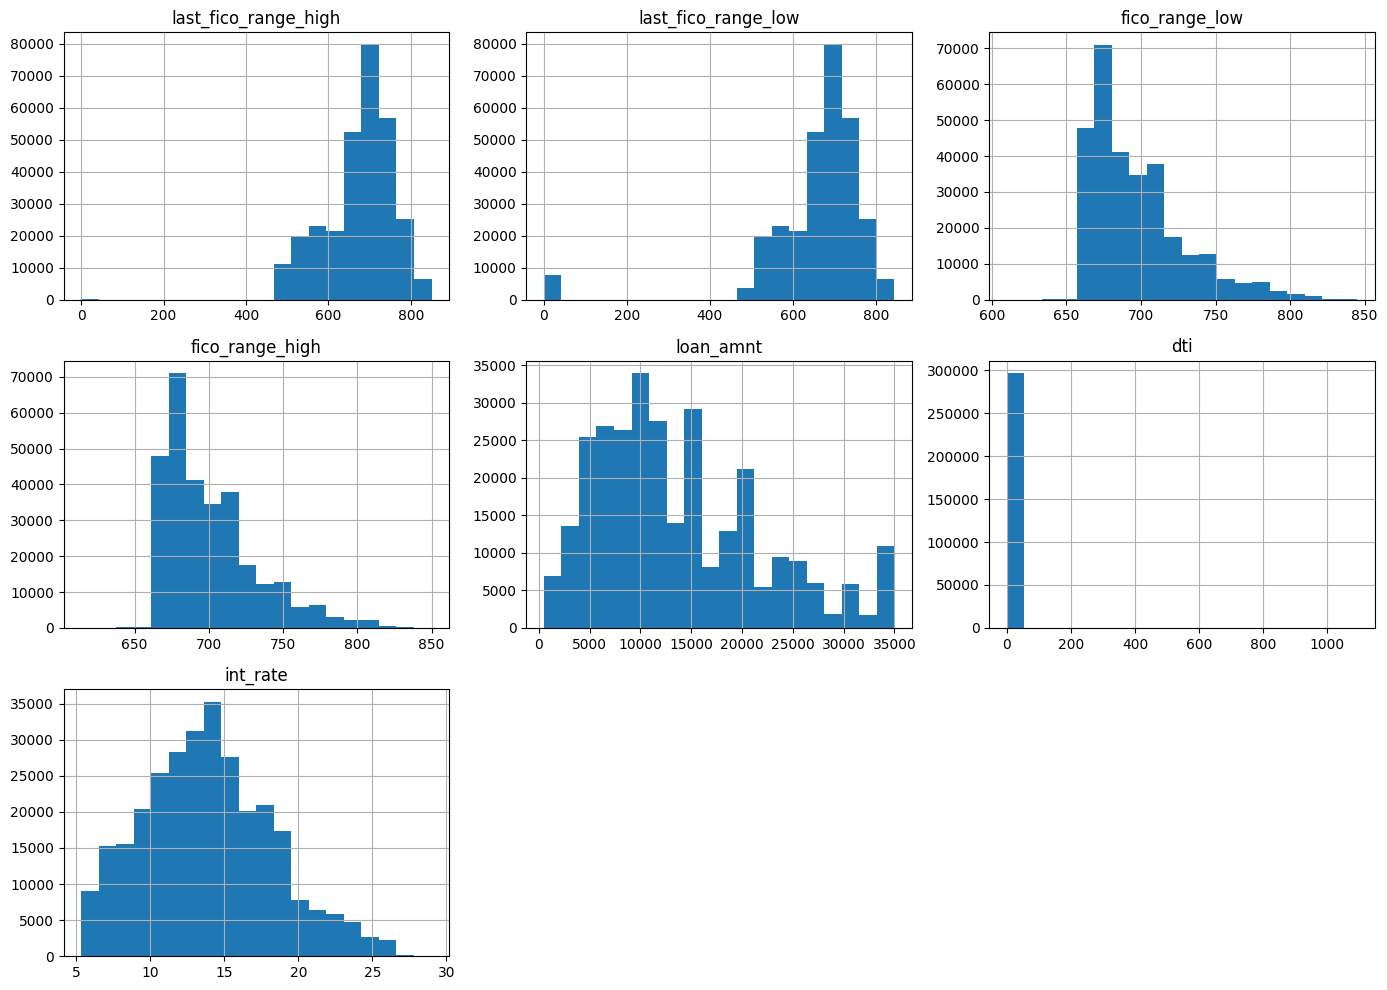

In [46]:
#plot feature distribution (part)
part_feature = df[["last_fico_range_high", "last_fico_range_low", "fico_range_low", "fico_range_high", "loan_amnt", "dti", "int_rate"]]
part_feature.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

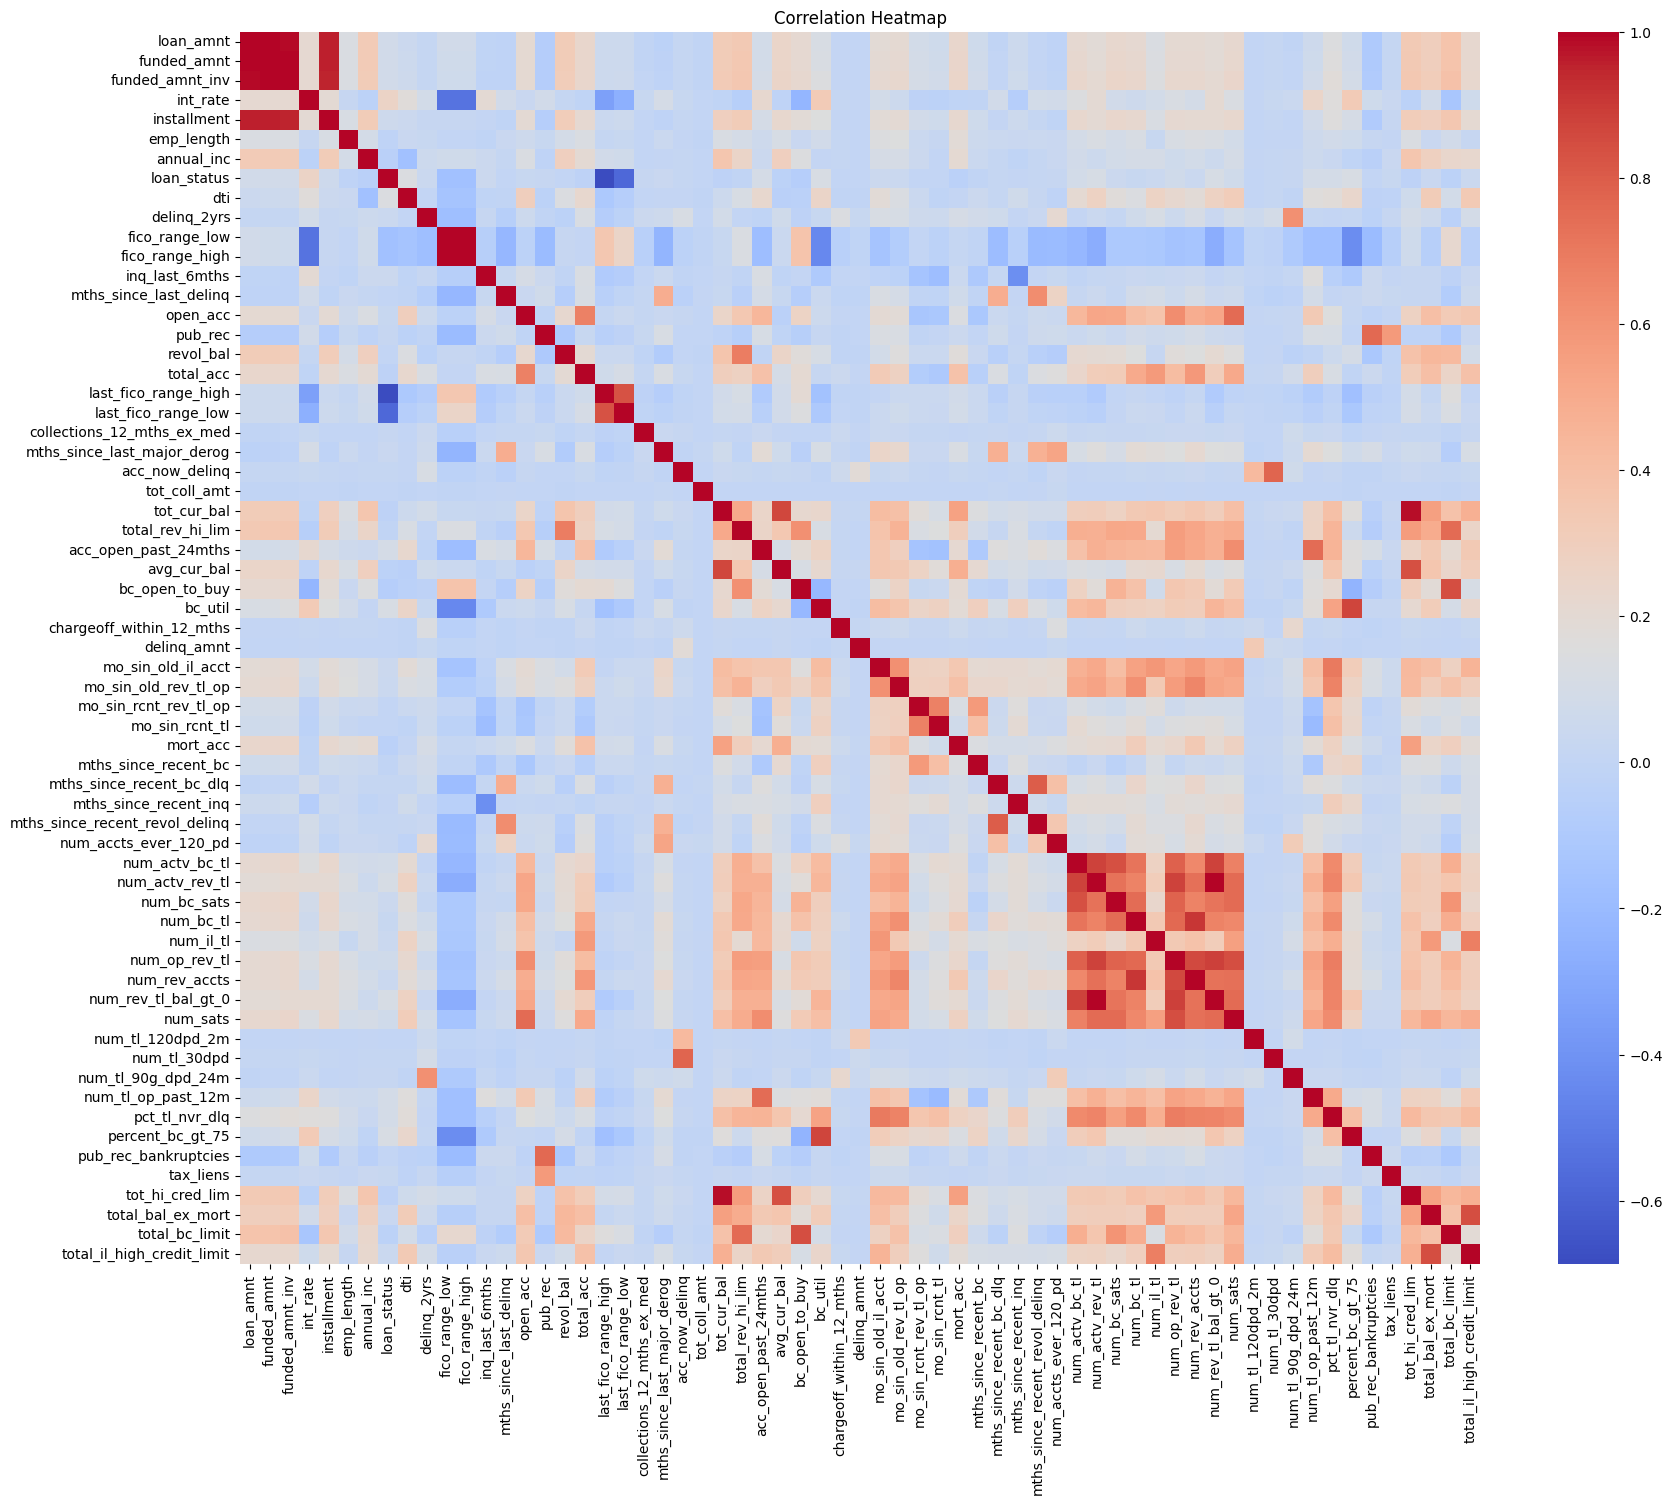

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
#Correlation heatmap
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Dummy Variables

In [ ]:
# one hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)

In [ ]:
df.columns = df.columns.astype(str)
df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)

In [ ]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,...,last_credit_pull_d_Oct_2015,last_credit_pull_d_Sep_2007,last_credit_pull_d_Sep_2008,last_credit_pull_d_Sep_2009,last_credit_pull_d_Sep_2010,last_credit_pull_d_Sep_2011,last_credit_pull_d_Sep_2012,last_credit_pull_d_Sep_2013,last_credit_pull_d_Sep_2014,last_credit_pull_d_Sep_2015
0,5000.0,5000.0,4975.0,10.65,162.87,10.0,24000.0,0.0,27.65,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,2500.0,15.27,59.83,0.5,30000.0,1.0,1.00,0.0,...,0,0,0,0,0,0,0,1,0,0
2,2400.0,2400.0,2400.0,15.96,84.33,10.0,12252.0,0.0,8.72,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,10000.0,13.49,339.31,10.0,49200.0,0.0,20.00,0.0,...,0,0,0,0,0,0,0,0,0,0
5,5000.0,5000.0,5000.0,7.90,156.46,3.0,36000.0,0.0,11.20,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421085,4000.0,4000.0,4000.0,8.67,126.59,10.0,50000.0,0.0,12.63,0.0,...,0,0,0,0,0,0,0,0,0,0
421086,10850.0,10850.0,10850.0,19.24,399.04,0.0,32000.0,1.0,29.44,0.0,...,0,0,0,0,0,0,0,0,0,0
421093,12000.0,12000.0,12000.0,19.99,317.86,1.0,64400.0,1.0,27.19,1.0,...,0,0,0,0,0,0,0,0,0,0
421095,0.0,0.0,0.0,0.00,0.00,0.0,0.0,NaN,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0


### Sampling

In [ ]:
# sample 5% of the data
df = df.sample(frac=0.05, random_state=42)

In [ ]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,...,last_credit_pull_d_Oct_2015,last_credit_pull_d_Sep_2007,last_credit_pull_d_Sep_2008,last_credit_pull_d_Sep_2009,last_credit_pull_d_Sep_2010,last_credit_pull_d_Sep_2011,last_credit_pull_d_Sep_2012,last_credit_pull_d_Sep_2013,last_credit_pull_d_Sep_2014,last_credit_pull_d_Sep_2015
123470,8000.0,8000.0,7950.0,14.33,274.71,10.0,50000.0,0.0,18.05,0.0,...,0,0,0,0,0,0,0,0,0,0
144745,16000.0,16000.0,16000.0,12.12,532.35,4.0,45000.0,0.0,12.48,2.0,...,0,0,0,0,0,0,0,0,0,0
161263,1900.0,1900.0,1900.0,14.33,65.25,4.0,75000.0,0.0,9.81,0.0,...,0,0,0,0,0,0,0,0,0,0
74330,16000.0,16000.0,16000.0,12.35,358.75,5.0,66000.0,0.0,16.13,0.0,...,0,0,0,0,0,0,0,0,0,0
184085,24800.0,24800.0,24800.0,13.65,843.40,10.0,54000.0,0.0,20.71,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180652,9000.0,9000.0,9000.0,8.90,285.78,0.5,44000.0,0.0,21.99,0.0,...,0,0,0,0,0,0,0,0,0,0
82435,35000.0,35000.0,35000.0,16.29,1235.52,1.0,209700.0,0.0,14.24,0.0,...,0,0,0,0,0,0,0,0,0,0
13754,7000.0,7000.0,7000.0,12.99,235.83,10.0,175000.0,0.0,9.38,0.0,...,0,0,0,0,0,0,0,0,0,0
30268,10000.0,10000.0,10000.0,16.45,353.78,0.0,47435.0,1.0,19.93,0.0,...,0,0,0,0,0,0,0,0,0,0


### Train-Test Split

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Feature Scaling

In [ ]:
# scale the float columns
scaler = StandardScaler()
float_columns = X_train.select_dtypes(include='float').columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[float_columns] = scaler.fit_transform(X_train[float_columns])
X_test_scaled[float_columns] = scaler.transform(X_test[float_columns])

In [ ]:
X_train_scaled

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,...,last_credit_pull_d_Oct_2015,last_credit_pull_d_Sep_2007,last_credit_pull_d_Sep_2008,last_credit_pull_d_Sep_2009,last_credit_pull_d_Sep_2010,last_credit_pull_d_Sep_2011,last_credit_pull_d_Sep_2012,last_credit_pull_d_Sep_2013,last_credit_pull_d_Sep_2014,last_credit_pull_d_Sep_2015
204950,-0.198038,-0.193567,-0.177821,-0.316964,-0.069913,1.180853,0.156862,0.151356,0.937265,-0.686691,...,0,0,0,0,0,0,0,0,0,0
11556,1.279404,1.287250,1.296909,-1.000652,1.435146,-0.442525,0.260398,1.821051,2.214350,-0.686691,...,0,0,0,0,0,0,0,0,0,0
28571,-0.444278,-0.440370,-0.426682,0.302914,-0.735303,-0.713088,-0.153664,-0.577238,0.937265,-0.058109,...,0,0,0,0,0,0,0,0,0,0
407582,-1.059879,-1.057377,-1.038080,-0.772756,-1.048862,-0.442525,-0.654861,-0.476045,-0.339819,-0.529546,...,0,0,0,0,0,0,0,0,0,0
308913,-0.154946,-0.150377,-0.134808,0.394072,0.054781,-0.171962,-0.402233,0.255079,-0.339819,0.256181,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385571,0.786924,0.793644,0.805332,0.097807,1.098680,0.639727,-0.257283,0.506799,-0.339819,-0.058109,...,0,0,0,0,0,0,0,0,0,0
79992,-0.493526,-0.489731,-0.472767,-0.950515,-0.450716,1.180853,-0.070918,0.634556,-0.339819,0.413327,...,0,0,0,0,0,0,0,0,0,0
32960,-0.444278,-0.440370,-0.429754,-1.399470,-0.435431,-1.389496,-0.464355,-2.030632,-0.339819,2.299072,...,0,0,0,0,0,0,0,0,0,0
626,0.479123,0.485141,0.491952,-1.426818,0.519916,-1.524777,-0.671427,0.117203,-0.339819,0.413327,...,0,0,0,0,0,0,0,0,0,0


## Model Building

### ANN

#### Hyperparameter Optimization

In [ ]:
def objective(trial):
    # Hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    num_units = trial.suggest_int('num_units', 64, 512)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    epochs = trial.suggest_int('epochs', 50, 200)

    # Build the model
    model = Sequential()
    model.add(Dense(num_units, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units // 2, activation='relu'))
        model.add(Dropout(dropout_rate))
        num_units = num_units // 2

    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["f1_score"])

    # Create a callback to stop training if the validation loss does not decrease for 10 epochs
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[callback],
    )

    # Return the best validation F1 score
    val_f1 = max(history.history['val_f1_score'])
    return val_f1

In [ ]:
study_ann = optuna.create_study(direction='maximize', study_name='ann_tuning')  # Maximize validation accuracy
study_ann.optimize(objective, n_trials=40, show_progress_bar=True)

# Print the best parameters and value
print("Best Parameters:", study_ann.best_params)
print("Best Validation Accuracy:", study_ann.best_value)

[I 2024-11-30 13:46:45,035] A new study created in memory with name: ann_tuning


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:46:54,570] Trial 0 finished with value: 0.3847351670265198 and parameters: {'learning_rate': 0.0008722771812175817, 'dropout_rate': 0.34788192807686313, 'num_units': 108, 'num_layers': 2, 'batch_size': 32, 'epochs': 112}. Best is trial 0 with value: 0.3847351670265198.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:47:13,735] Trial 1 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.00011851486016435845, 'dropout_rate': 0.31692506496020123, 'num_units': 109, 'num_layers': 4, 'batch_size': 64, 'epochs': 139}. Best is trial 0 with value: 0.3847351670265198.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:47:36,572] Trial 2 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.0001873743959966473, 'dropout_rate': 0.4182991910917987, 'num_units': 196, 'num_layers': 2, 'batch_size': 512, 'epochs': 128}. Best is trial 0 with value: 0.3847351670265198.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:48:10,466] Trial 3 finished with value: 0.38533538579940796 and parameters: {'learning_rate': 0.0002340626847543246, 'dropout_rate': 0.35473340317841706, 'num_units': 463, 'num_layers': 4, 'batch_size': 32, 'epochs': 61}. Best is trial 3 with value: 0.38533538579940796.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:48:17,493] Trial 4 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.00014683065433990602, 'dropout_rate': 0.22134419881238823, 'num_units': 77, 'num_layers': 4, 'batch_size': 512, 'epochs': 142}. Best is trial 3 with value: 0.38533538579940796.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:49:07,166] Trial 5 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 1.8114025426983286e-05, 'dropout_rate': 0.41811449161159436, 'num_units': 413, 'num_layers': 2, 'batch_size': 64, 'epochs': 170}. Best is trial 3 with value: 0.38533538579940796.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:49:13,730] Trial 6 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.00013614667658047637, 'dropout_rate': 0.4343057437846384, 'num_units': 90, 'num_layers': 2, 'batch_size': 128, 'epochs': 198}. Best is trial 3 with value: 0.38533538579940796.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:49:32,866] Trial 7 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 5.5580628812503796e-05, 'dropout_rate': 0.3866569881404891, 'num_units': 313, 'num_layers': 3, 'batch_size': 64, 'epochs': 103}. Best is trial 3 with value: 0.38533538579940796.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:49:52,716] Trial 8 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 3.7047181238129965e-05, 'dropout_rate': 0.46281573636269413, 'num_units': 114, 'num_layers': 2, 'batch_size': 64, 'epochs': 198}. Best is trial 3 with value: 0.38533538579940796.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:49:57,019] Trial 9 finished with value: 0.385786771774292 and parameters: {'learning_rate': 0.0005332128669407188, 'dropout_rate': 0.33701352116291966, 'num_units': 168, 'num_layers': 3, 'batch_size': 64, 'epochs': 116}. Best is trial 9 with value: 0.385786771774292.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:50:01,567] Trial 10 finished with value: 0.3851851522922516 and parameters: {'learning_rate': 0.0009689935328322545, 'dropout_rate': 0.2633754789063931, 'num_units': 259, 'num_layers': 3, 'batch_size': 256, 'epochs': 75}. Best is trial 9 with value: 0.385786771774292.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:50:17,933] Trial 11 finished with value: 0.3923748731613159 and parameters: {'learning_rate': 0.0004103469940758689, 'dropout_rate': 0.3092524997577477, 'num_units': 483, 'num_layers': 4, 'batch_size': 32, 'epochs': 51}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

Exception ignored in: <function tqdm.__del__ at 0x31c4085e0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/tqdm/notebook.py", line 275, in close
    super().close()
  File "/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/tqdm/std.py", line 1275, in close
    self._decr_instances(self)
  File "/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/tqdm/std.py", line 696, in _decr_instances
    with cls._lock:
         ^^^^^^^^^
AttributeError: type object 'tqdm' has no attribute '_lock'
Exception ignored in: <function tqdm.__del_

[I 2024-11-30 13:50:28,487] Trial 12 finished with value: 0.3883647322654724 and parameters: {'learning_rate': 0.0004031136305653908, 'dropout_rate': 0.29026164072542493, 'num_units': 358, 'num_layers': 3, 'batch_size': 32, 'epochs': 86}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:50:43,626] Trial 13 finished with value: 0.38867029547691345 and parameters: {'learning_rate': 0.00037122502860763854, 'dropout_rate': 0.2750412554748442, 'num_units': 504, 'num_layers': 4, 'batch_size': 32, 'epochs': 51}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:50:57,555] Trial 14 finished with value: 0.39144212007522583 and parameters: {'learning_rate': 0.0004163933339474099, 'dropout_rate': 0.23608000716884386, 'num_units': 511, 'num_layers': 4, 'batch_size': 32, 'epochs': 50}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:51:30,970] Trial 15 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 5.6897295628841876e-05, 'dropout_rate': 0.22319727209033946, 'num_units': 422, 'num_layers': 4, 'batch_size': 32, 'epochs': 81}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:51:42,203] Trial 16 finished with value: 0.3889763355255127 and parameters: {'learning_rate': 0.00025608571086166584, 'dropout_rate': 0.25097396110917686, 'num_units': 510, 'num_layers': 4, 'batch_size': 128, 'epochs': 51}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:51:54,845] Trial 17 finished with value: 0.38593748211860657 and parameters: {'learning_rate': 0.000591887906855487, 'dropout_rate': 0.20090065087271128, 'num_units': 376, 'num_layers': 4, 'batch_size': 256, 'epochs': 96}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:06,409] Trial 18 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 1.2712769316701226e-05, 'dropout_rate': 0.2960961191194772, 'num_units': 460, 'num_layers': 3, 'batch_size': 32, 'epochs': 68}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:16,159] Trial 19 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 7.881092035284001e-05, 'dropout_rate': 0.24097867454734856, 'num_units': 289, 'num_layers': 4, 'batch_size': 32, 'epochs': 164}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:26,220] Trial 20 finished with value: 0.3865414261817932 and parameters: {'learning_rate': 0.0003046136228822387, 'dropout_rate': 0.3126463180327568, 'num_units': 468, 'num_layers': 4, 'batch_size': 32, 'epochs': 93}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:32,978] Trial 21 finished with value: 0.38714730739593506 and parameters: {'learning_rate': 0.0002607676395569824, 'dropout_rate': 0.23983590874636304, 'num_units': 496, 'num_layers': 4, 'batch_size': 128, 'epochs': 55}. Best is trial 11 with value: 0.3923748731613159.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:39,286] Trial 22 finished with value: 0.40162596106529236 and parameters: {'learning_rate': 0.0005916947343979174, 'dropout_rate': 0.2575686339812242, 'num_units': 512, 'num_layers': 4, 'batch_size': 128, 'epochs': 50}. Best is trial 22 with value: 0.40162596106529236.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:44,429] Trial 23 finished with value: 0.41235387325286865 and parameters: {'learning_rate': 0.0006625675363958325, 'dropout_rate': 0.27720441844767485, 'num_units': 417, 'num_layers': 4, 'batch_size': 128, 'epochs': 69}. Best is trial 23 with value: 0.41235387325286865.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:49,329] Trial 24 finished with value: 0.40759071707725525 and parameters: {'learning_rate': 0.0006400832911934723, 'dropout_rate': 0.28291708170898067, 'num_units': 418, 'num_layers': 3, 'batch_size': 128, 'epochs': 68}. Best is trial 23 with value: 0.41235387325286865.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:54,197] Trial 25 finished with value: 0.4064171016216278 and parameters: {'learning_rate': 0.0006818644778495406, 'dropout_rate': 0.2787840660655458, 'num_units': 417, 'num_layers': 3, 'batch_size': 128, 'epochs': 75}. Best is trial 23 with value: 0.41235387325286865.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:53:58,737] Trial 26 finished with value: 0.40048637986183167 and parameters: {'learning_rate': 0.0006295670708449631, 'dropout_rate': 0.2802048374095423, 'num_units': 373, 'num_layers': 3, 'batch_size': 128, 'epochs': 70}. Best is trial 23 with value: 0.41235387325286865.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:03,872] Trial 27 finished with value: 0.41515782475471497 and parameters: {'learning_rate': 0.0007642669014898246, 'dropout_rate': 0.32818146907861834, 'num_units': 424, 'num_layers': 3, 'batch_size': 128, 'epochs': 83}. Best is trial 27 with value: 0.41515782475471497.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:08,399] Trial 28 finished with value: 0.39488404989242554 and parameters: {'learning_rate': 0.0009844456933890047, 'dropout_rate': 0.3713173288993958, 'num_units': 332, 'num_layers': 3, 'batch_size': 128, 'epochs': 88}. Best is trial 27 with value: 0.41515782475471497.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:14,270] Trial 29 finished with value: 0.41828954219818115 and parameters: {'learning_rate': 0.0007745667920846888, 'dropout_rate': 0.33580758738652455, 'num_units': 439, 'num_layers': 3, 'batch_size': 128, 'epochs': 103}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:17,809] Trial 30 finished with value: 0.3923748731613159 and parameters: {'learning_rate': 0.0007990706695392541, 'dropout_rate': 0.335699262623905, 'num_units': 244, 'num_layers': 3, 'batch_size': 128, 'epochs': 109}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:24,096] Trial 31 finished with value: 0.40491801500320435 and parameters: {'learning_rate': 0.0007762554779819662, 'dropout_rate': 0.3586886693904051, 'num_units': 438, 'num_layers': 3, 'batch_size': 128, 'epochs': 98}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:30,030] Trial 32 finished with value: 0.39221909642219543 and parameters: {'learning_rate': 0.0004772198993983111, 'dropout_rate': 0.3266153787810106, 'num_units': 393, 'num_layers': 3, 'batch_size': 128, 'epochs': 81}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:34,887] Trial 33 finished with value: 0.39393937587738037 and parameters: {'learning_rate': 0.0007876909926235388, 'dropout_rate': 0.3791827042485392, 'num_units': 341, 'num_layers': 3, 'batch_size': 128, 'epochs': 116}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:43,957] Trial 34 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.00019901400717382085, 'dropout_rate': 0.3043640337446434, 'num_units': 437, 'num_layers': 3, 'batch_size': 512, 'epochs': 67}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:49,158] Trial 35 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.00030985516718813963, 'dropout_rate': 0.4982900162056881, 'num_units': 392, 'num_layers': 2, 'batch_size': 128, 'epochs': 130}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:54:55,431] Trial 36 finished with value: 0.39456865191459656 and parameters: {'learning_rate': 0.0004996761534140835, 'dropout_rate': 0.3450294978478053, 'num_units': 463, 'num_layers': 3, 'batch_size': 128, 'epochs': 106}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:55:01,027] Trial 37 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.0006881799347222444, 'dropout_rate': 0.3973445545667314, 'num_units': 439, 'num_layers': 2, 'batch_size': 512, 'epochs': 62}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:55:09,329] Trial 38 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 9.750009748949941e-05, 'dropout_rate': 0.3229176404096296, 'num_units': 407, 'num_layers': 3, 'batch_size': 256, 'epochs': 88}. Best is trial 29 with value: 0.41828954219818115.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



[I 2024-11-30 13:55:15,391] Trial 39 finished with value: 0.3845854103565216 and parameters: {'learning_rate': 0.0001771331566637944, 'dropout_rate': 0.3671707970695096, 'num_units': 314, 'num_layers': 3, 'batch_size': 128, 'epochs': 123}. Best is trial 29 with value: 0.41828954219818115.
Best Parameters: {'learning_rate': 0.0007745667920846888, 'dropout_rate': 0.33580758738652455, 'num_units': 439, 'num_layers': 3, 'batch_size': 128, 'epochs': 103}
Best Validation Accuracy: 0.41828954219818115


In [ ]:
# Visualizations
vis.plot_optimization_history(study_ann).show()
vis.plot_param_importances(study_ann).show()

#### Model Training

In [ ]:
best_params_ann = study_ann.best_params

In [ ]:
# Build the final model with best parameters
ann_model = Sequential()
ann_model.add(Dense(best_params_ann['num_units'], activation='relu', input_shape=(X_train_scaled.shape[1],)))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(best_params_ann['dropout_rate']))

for _ in range(best_params_ann['num_layers'] - 1):
    ann_model.add(Dense(best_params_ann['num_units'] // 2, activation='relu'))
    ann_model.add(Dropout(best_params_ann['dropout_rate']))
    best_params_ann['num_units'] = best_params_ann['num_units'] // 2

ann_model.add(Dense(1, activation='sigmoid'))

/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# compile the model
ann_model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='binary_crossentropy',
                  metrics=['f1_score'])

In [ ]:
# create a callback to stop training if the validation loss does not decrease for 10 epochs
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# fit the model
history = ann_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=best_params_ann['epochs'],
                        batch_size=best_params_ann['batch_size'],
                        callbacks=[callback])

Epoch 1/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - f1_score: 0.3816 - loss: 0.4592 - val_f1_score: 0.3846 - val_loss: 0.4837
Epoch 2/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.3805 - loss: 0.2536 - val_f1_score: 0.3846 - val_loss: 0.3685
Epoch 3/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.3885 - loss: 0.2012 - val_f1_score: 0.3846 - val_loss: 0.3164
Epoch 4/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.3866 - loss: 0.1668 - val_f1_score: 0.3846 - val_loss: 0.2520
Epoch 5/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.3850 - loss: 0.1362 - val_f1_score: 0.3846 - val_loss: 0.2401
Epoch 6/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.3933 - loss: 0.1150 - val_f1_score: 0.3846 - val_loss: 0.2622
Epoch 7/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.3944 - loss: 0.0956 - val_f1_score: 0.3858 - val_loss: 0.2908
Epoch 8/103
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.3921 - loss: 0.0830 - val_f1_score: 0.3899 - 

In [ ]:
# print model summary
ann_model.summary()

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_340 (Dense)               │ (None, 439)            │     1,020,236 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 439)            │         1,756 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_256 (Dropout)           │ (None, 439)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 219)            │        96,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_257 (Dropout)           │ (None, 219)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 109)            │        23,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_258 (Dropout)           │ (None, 109)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 1)              │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,425,572 (13.07 MB)

 Trainable params: 1,141,564 (4.35 MB)

 Non-trainable params: 878 (3.43 KB)

 Optimizer params: 2,283,130 (8.71 MB)

#### Model Evaluation

In [ ]:
# print classification report
y_pred_proba_train = ann_model.predict(X_train_scaled)
y_pred_ann_train = y_pred_proba_train > 0.5

y_pred_proba_test = ann_model.predict(X_test_scaled)
y_pred_ann_test = y_pred_proba_test > 0.5

print(classification_report(y_test, y_pred_ann_test))

325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      3378
         1.0       0.87      0.75      0.80      1067

    accuracy                           0.91      4445
   macro avg       0.90      0.86      0.87      4445
weighted avg       0.91      0.91      0.91      4445



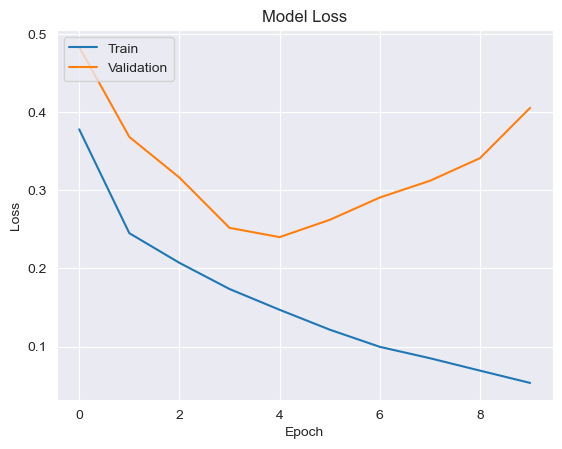

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model Saving

In [ ]:
ann_model.save('../models/ann_model.keras')

### Random Forest

#### Hyperparameter Optimization

In [ ]:
# Hyperparameter search space
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the Random Forest model with suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Perform cross-validation with Stratified K-Folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Compute cross-validated F1 score
    f1_scores = cross_val_score(rf, X_train, y_train, scoring=make_scorer(f1_score, average='macro'), cv=cv, n_jobs=-1)

    # Return the mean F1 score from the cross-validation
    return np.mean(f1_scores)

In [ ]:
study_rf = optuna.create_study(direction='maximize', study_name='rf_tuning')  # Maximize validation accuracy
study_rf.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2024-11-30 12:21:39,690] A new study created in memory with name: rf_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-11-30 12:21:44,873] Trial 0 finished with value: 0.431788293897883 and parameters: {'n_estimators': 399, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.431788293897883.
[I 2024-11-30 12:21:52,688] Trial 1 finished with value: 0.4480560868358084 and parameters: {'n_estimators': 476, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.4480560868358084.
[I 2024-11-30 12:21:59,672] Trial 2 finished with value: 0.4869453090367017 and parameters: {'n_estimators': 438, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.4869453090367017.
[I 2024-11-30 12:22:01,850] Trial 3 finished with value: 0.431788293897883 and parameters: {'n_estimators': 424, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 2 with value: 0.4869453090367017.


In [ ]:
vis.plot_optimization_history(study_rf).show()
vis.plot_param_importances(study_rf).show()

#### Model Training

In [ ]:
# Get the best hyperparameters
best_params_rf = study_rf.best_params

In [ ]:
# Create the Random Forest model with best hyperparameters
rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)

In [ ]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=None, min_samples_leaf=7,
                       min_samples_split=4, n_estimators=142, random_state=42)

#### Model Evaluation

In [ ]:
# Print classification report
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      3378
         1.0       0.84      0.80      0.82      1067

    accuracy                           0.91      4445
   macro avg       0.89      0.88      0.88      4445
weighted avg       0.91      0.91      0.91      4445



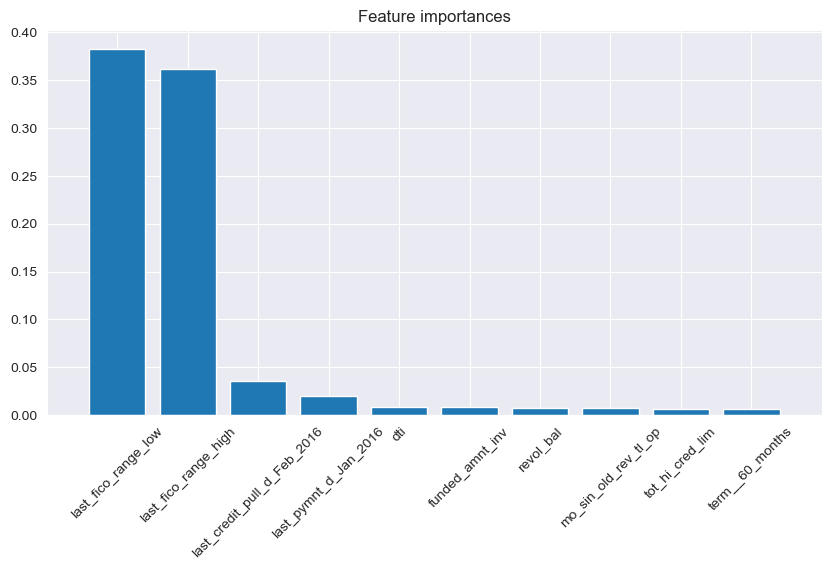

In [ ]:
# plot feature importances top 10
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), X_train.columns[indices], rotation=45)
plt.xlim([-1, 10])
plt.show()

#### Model Saving

In [ ]:
# save the model with pickle
pickle.dump(rf, open('../models/rf_model.pkl', 'wb'))

### AdaBoost

#### Hyperparameter Optimization

In [ ]:
def objective(trial):
    # Hyperparameter search space for the base Decision Tree
    max_depth = trial.suggest_int('max_depth', 1, 10)  # Depth of the tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split a node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Minimum samples in a leaf node
    max_features = trial.suggest_categorical('max_features',
                                             [None, 'sqrt', 'log2'])  # Features to consider for splitting

    # Hyperparameter search space for AdaBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    # Define the base estimator (Decision Tree)
    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Define the AdaBoost model
    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm='SAMME',
        random_state=42
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(f1_score, average='macro'), cv=cv, n_jobs=-1)

    # Return the mean F1 score
    return scores.mean()

In [ ]:
# Optimize hyperparameters
study_ada = optuna.create_study(direction='maximize', study_name='ada_tuning')  # Maximize validation accuracy
study_ada.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2024-11-30 12:51:16,819] A new study created in memory with name: ada_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-11-30 12:51:36,676] Trial 0 finished with value: 0.8775961639857748 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 259, 'learning_rate': 0.23724342825348113}. Best is trial 0 with value: 0.8775961639857748.
[I 2024-11-30 12:52:57,800] Trial 1 finished with value: 0.8792569690502583 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'n_estimators': 444, 'learning_rate': 0.3575826792648292}. Best is trial 1 with value: 0.8792569690502583.
[I 2024-11-30 12:53:13,181] Trial 2 finished with value: 0.8452546084477938 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'n_estimators': 133, 'learning_rate': 0.47303112688686383}. Best is trial 1 with value: 0.8792569690502583.
[I 2024-11-30 12:53:47,020] Trial 3 finished with value: 0.7629383213695171 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_

In [ ]:
# Visualizations
vis.plot_optimization_history(study_ada).show()
vis.plot_param_importances(study_ada).show()

#### Model Training

In [ ]:
# Get the best hyperparameters
best_params_ada = study_ada.best_params

In [ ]:
# Create the AdaBoost model with best hyperparameters
dt = DecisionTreeClassifier(
    max_depth=best_params_ada['max_depth'],
    min_samples_split=best_params_ada['min_samples_split'],
    min_samples_leaf=best_params_ada['min_samples_leaf'],
    max_features=best_params_ada['max_features'],
    random_state=42
)

ab = AdaBoostClassifier(
    estimator=dt,
    n_estimators=best_params_ada['n_estimators'],
    learning_rate=best_params_ada['learning_rate'],
    algorithm='SAMME',
    random_state=42
)

In [ ]:
# Fit the model
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=7,
                                                    min_samples_leaf=8,
                                                    min_samples_split=6,
                                                    random_state=42),
                   learning_rate=0.15980159111350184, n_estimators=197,
                   random_state=42)

#### Model Evaluation

In [ ]:
# Print classification report
y_pred_ada_train = ab.predict(X_train)
y_pred_ada_test = ab.predict(X_test)
print(classification_report(y_test, y_pred_ada_test))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      3378
         1.0       0.85      0.81      0.83      1067

    accuracy                           0.92      4445
   macro avg       0.90      0.88      0.89      4445
weighted avg       0.92      0.92      0.92      4445



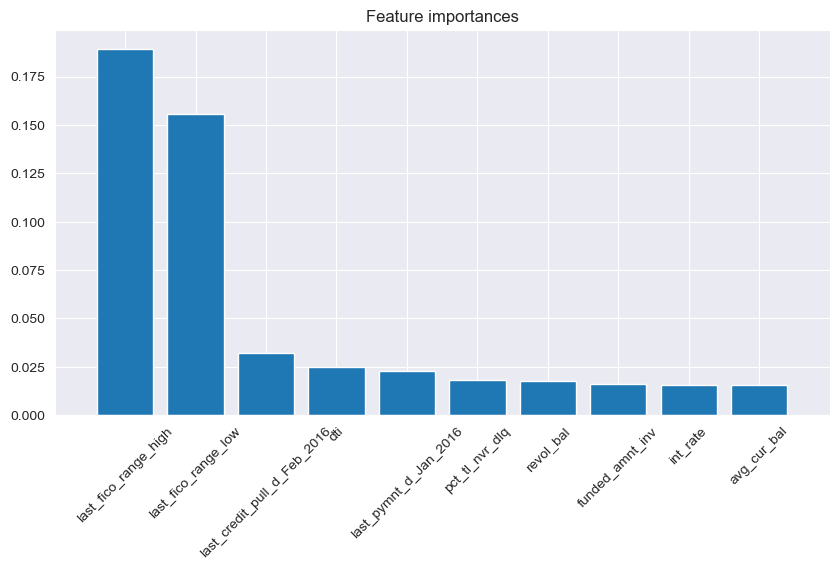

In [ ]:
# Plot feature importances
importances = ab.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), X_train.columns[indices], rotation=45)
plt.xlim([-1, 10])
plt.show()

#### Model Saving

In [ ]:
# Save the model with pickle
pickle.dump(ab, open('../models/ada_model.pkl', 'wb'))

### XGBoost

#### Hyperparameter Optimization

In [ ]:
# Hyperparameter search space
def objective(trial):
    # Define the hyperparameter search space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 50.0),  # Important for imbalanced datasets
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),  # L2 regularization
    }

    # Initialize XGBoost model
    model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss",
                              random_state=42, **param)

    # Cross-validation with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring=make_scorer(f1_score, average="macro"), cv=cv, n_jobs=-1)

    # Return mean F1 score
    return scores.mean()

In [ ]:
# Optimize hyperparameters
study_xg = optuna.create_study(direction='maximize', study_name='xg_tuning')  # Maximize validation accuracy
study_xg.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2024-11-30 14:04:48,163] A new study created in memory with name: xg_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-11-30 14:04:56,145] Trial 0 finished with value: 0.1936085887723875 and parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.0019720444777277927, 'subsample': 0.9237309910027665, 'colsample_bytree': 0.8370264996244877, 'gamma': 0.46364591872174454, 'min_child_weight': 3, 'scale_pos_weight': 10.157781699267622, 'reg_alpha': 0.7811169888866043, 'reg_lambda': 2.218802965055222}. Best is trial 0 with value: 0.1936085887723875.
[I 2024-11-30 14:05:10,343] Trial 1 finished with value: 0.8840497337497668 and parameters: {'n_estimators': 302, 'max_depth': 10, 'learning_rate': 0.1743130309190094, 'subsample': 0.8932531249218232, 'colsample_bytree': 0.8256170209186762, 'gamma': 0.19934026615076872, 'min_child_weight': 2, 'scale_pos_weight': 24.61757687768437, 'reg_alpha': 1.1348355712982394, 'reg_lambda': 1.0751238602014834}. Best is trial 1 with value: 0.8840497337497668.
[I 2024-11-30 14:05:28,451] Trial 2 finished with value: 0.1936085887723875 and parameters: {'n_estim

In [ ]:
# Visualizations
vis.plot_optimization_history(study_xg).show()
vis.plot_param_importances(study_xg).show()

#### Model Training

In [ ]:
# Get the best hyperparameters
best_params_xg = study_xg.best_params

In [ ]:
# Initialize XGBoost model with best hyperparameters
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    **best_params_xg
)

In [ ]:
# Fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8256170209186762, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.19934026615076872, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1743130309190094,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=302, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### Model Evaluation

In [ ]:
# Print classification report
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb_test))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      3378
         1.0       0.79      0.87      0.83      1067

    accuracy                           0.91      4445
   macro avg       0.87      0.90      0.89      4445
weighted avg       0.92      0.91      0.92      4445



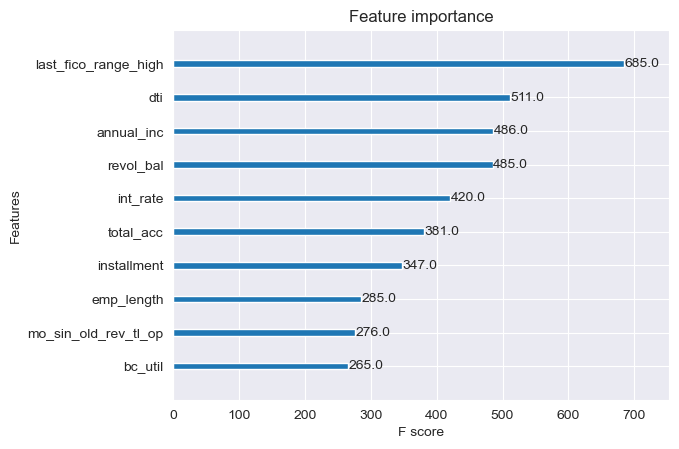

In [ ]:
# Plot feature importances
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.show()

#### Model Saving

In [ ]:
# Save the model with pickle
pickle.dump(xgb_model, open('../models/xgb_model.pkl', 'wb'))

## Summary

In [ ]:
models = ['ANN', 'Random Forest', 'AdaBoost', 'XGBoost']
predictions_train = [y_pred_ann_train, y_pred_rf_train, y_pred_ada_train, y_pred_xgb_train]
predictions_test = [y_pred_ann_test, y_pred_rf_test, y_pred_ada_test, y_pred_xgb_test]

utils.evaluate_models(models=models, predictions_train=predictions_train, predictions_test=predictions_test, X=X,
                      y_train=y_train, y_test=y_test)

,,ANN,Random Forest,AdaBoost,XGBoost
Metric,Type,,,,
Accuracy,Train,0.956803,0.946196,0.969048,0.999807
Overall Precision,Train,0.95643,0.94567,0.968997,0.999807
Overall Recall,Train,0.956803,0.946196,0.969048,0.999807
Overall F1 Score,Train,0.956309,0.945814,0.969021,0.999807
Positive Precision,Train,0.937822,0.904184,0.937828,0.999197
Negative Precision,Train,0.962309,0.958777,0.978845,1.0
Positive Recall,Train,0.878313,0.867871,0.932932,1.0
Negative Recall,Train,0.981601,0.970943,0.980459,0.999746
Positive F1 Score,Train,0.907092,0.885656,0.935373,0.999599
